In [1]:
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
import torch
import torchkbnufft as tkbn

In [2]:
#res in cm
res = 0.1
#fov in cm
fov_x = 25
fov_y = 25

pixels_x = int(fov_x/res)
pixels_y = int(fov_y/res)
pixels = pixels_x*pixels_y
print(pixels_x)
t1_myelin = 4.0e-1 
t1_wm = 8.5e-1      
t2_myelin = 5.0e-2  
t2_wm = 5.0e-2     
t2_star_myelin = 3.0e-2  
t2_star_wm = 7.0e-2    
inv_time = np.log(2)*t1_wm
echo_time = 5e-5

250


0.5405962334298786
0.0
0.2702981167149393


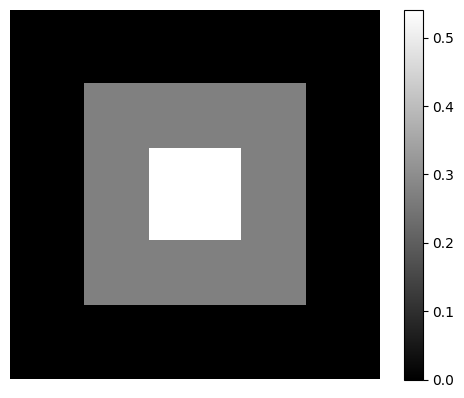

In [3]:
image = np.ones((pixels_x, pixels_y))

mxy_myelin = (1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin))
mxy_wm = (1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))
mxy_mixed = 0.5*((1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))) + 0.5*((1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin)))

print(mxy_myelin)
print(mxy_wm)
print(mxy_mixed)

outer_square_size = int(1.0 * pixels_x) 
middle_square_size = int(0.6 * pixels_x)
inner_square_size = int(0.25 * pixels_x)  

# Calculate starting and ending indices for each square to center them
outer_start = (pixels_x - outer_square_size) // 2
outer_end = outer_start + outer_square_size

middle_start = (pixels_x - middle_square_size) // 2
middle_end = middle_start + middle_square_size

inner_start = (pixels_x - inner_square_size) // 2
inner_end = inner_start + inner_square_size

# Define the intensity values for each section
# Outermost square (100% WM - white, intensity = 1)
image[outer_start:outer_end, outer_start:outer_end] = mxy_wm  # 100% WM

# Middle square (50/50 of WM and myelin - medium gray)
image[middle_start:middle_end, middle_start:middle_end] = mxy_mixed  # 50/50 of WM and myelin (gray)

# Innermost square (100% myelin - black, intensity = 0)
image[inner_start:inner_end, inner_start:inner_end] = mxy_myelin  # 100% myelin (black)


# Display the image using matplotlib
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.axis('off')  # Turn off axis
plt.colorbar()
plt.show()



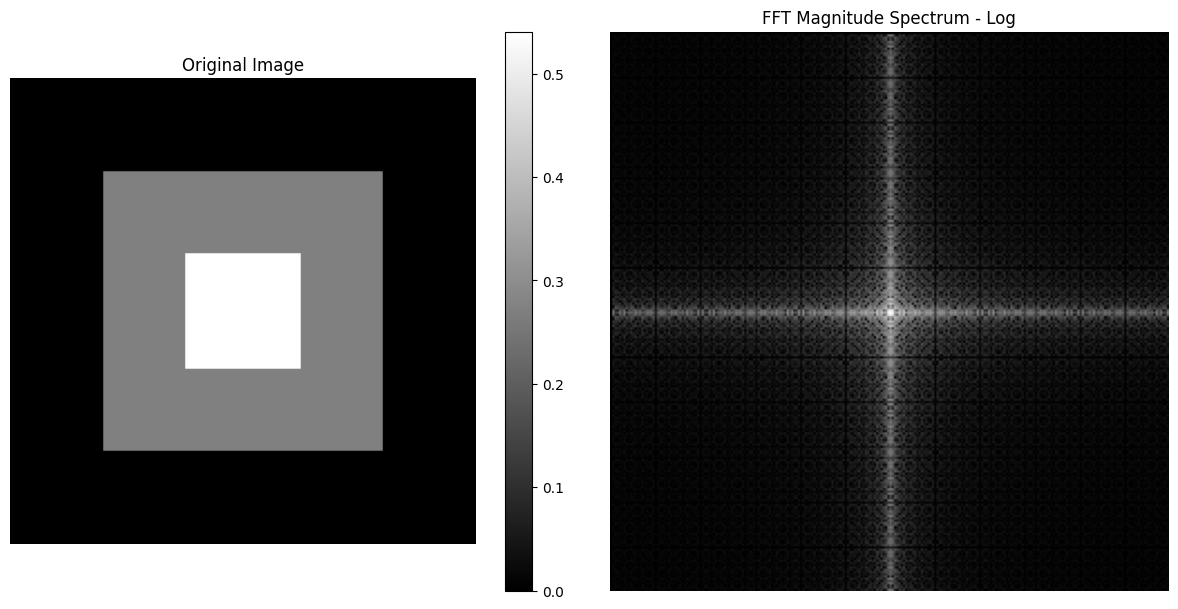

In [4]:
f_image = np.fft.fft2(image)

fft_image_shifted = np.fft.fftshift(f_image)  # Shift the zero-frequency component to the center

# Compute the magnitude spectrum
magnitude_spectrum = np.log(np.abs(fft_image_shifted) + 1)  # Log to enhance visibility

# Plot the original image and its FFT magnitude spectrum
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("FFT Magnitude Spectrum - Log")
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
filterwarnings("ignore") # ignore floor divide warnings
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


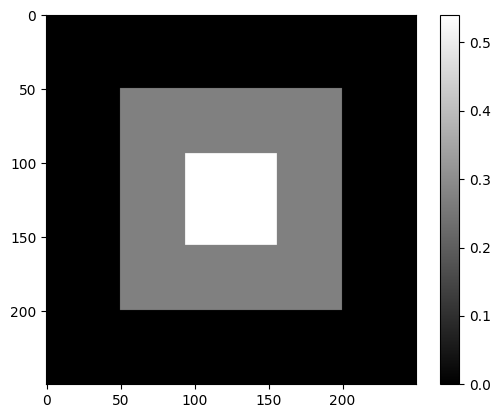

(250, 250) (500, 500)


In [6]:
# create a simple shepp logan phantom and plot it
#image = shepp_logan_phantom().astype(complex)
plt.imshow(np.absolute(image))
plt.gray()
plt.colorbar()
plt.show()
im_size = image.shape
grid_size = (tuple(int(dim * 2) for dim in im_size))
print(im_size,grid_size)
#spokelength = image.shape[-1] * 2
#grid_size = (spokelength, spokelength)
#print(spokelength,grid_size)

In [7]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image_t = torch.tensor(image).to(device).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image_t.shape))

image shape: torch.Size([1, 1, 250, 250])


k-space trajectory shape: (2, 62500)


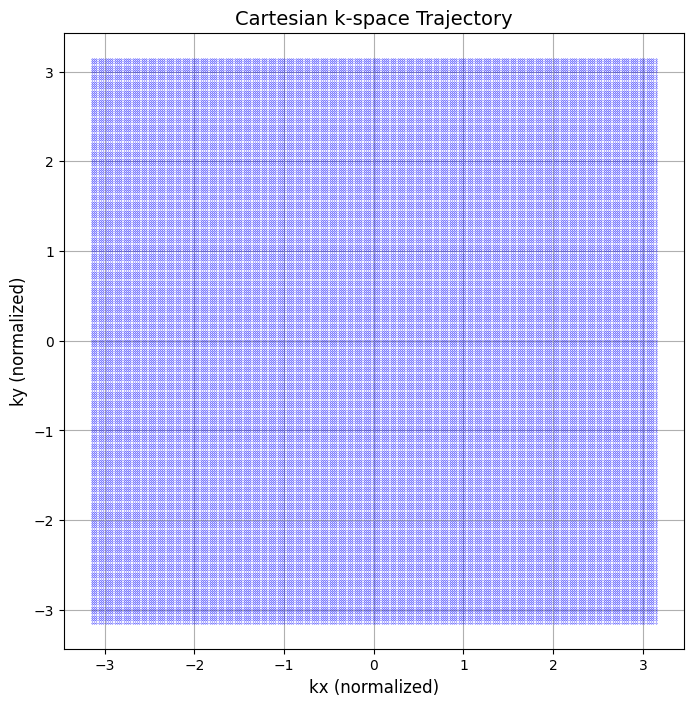

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the image size (number of pixels along each dimension)
x_pixels = 250
y_pixels = 250
res_mm = 0.25
max_r = 0.5/res_mm

f = 1
# Generate the k-space coordinates
kx = np.linspace(-max_r, max_r, f*x_pixels, endpoint=False)  # Frequency space in x
ty = np.linspace(-max_r, max_r, f*y_pixels, endpoint=False)  # Frequency space in y

# Create a Cartesian grid of k-space points
kx_grid, ky_grid = np.meshgrid(kx, ty, indexing='ij')

# Combine kx and ky into a single array
ktraj = np.stack((kx_grid.flatten(), ky_grid.flatten()), axis=0)

# Find min and max values across all axes
k_min = np.min(ktraj)
k_max = np.max(ktraj)

# Scale to [-pi, pi]
ktraj_scaled = (ktraj - k_min) / (k_max - k_min) * (2 * np.pi) - np.pi
ktraj = ktraj_scaled

# ktraj is a 2xN array, where N = x_pixels * y_pixels
# Rows represent kx and ky coordinates

print("k-space trajectory shape:", ktraj.shape)

# Visualize the k-space trajectory
plt.figure(figsize=(8, 8))
plt.plot(ktraj[0], ktraj[1], 'b.', markersize=0.5)
plt.title("Cartesian k-space Trajectory", fontsize=14)
plt.xlabel("kx (normalized)", fontsize=12)
plt.ylabel("ky (normalized)", fontsize=12)
plt.grid(True)
plt.axis('equal')
plt.show()


In [9]:
# convert k-space trajectory to a tensor
ktraj = torch.tensor(ktraj).to(device)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([2, 62500])


In [10]:
print(im_size,grid_size)

# create NUFFT objects, use 'ortho' for orthogonal FFTs
nufft_ob = tkbn.KbNufft(
    im_size=im_size,
    grid_size=grid_size,
).to(image_t)
adjnufft_ob = tkbn.KbNufftAdjoint(
    im_size=im_size,
    grid_size=grid_size,
).to(image_t)

print(nufft_ob)
print(adjnufft_ob)

(250, 250) (500, 500)

KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (250, 250)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (250, 250)



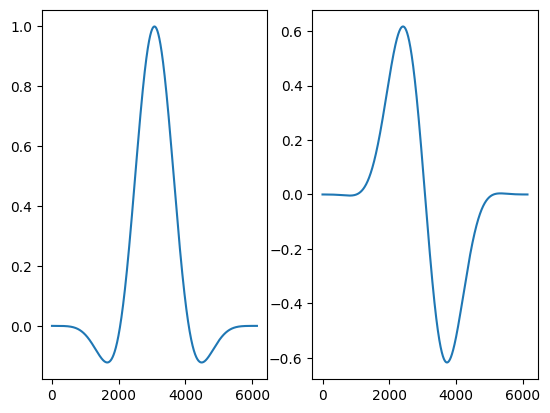

In [11]:
# plot the kernel
fig, axs = plt.subplots(1, 2)
axs.flat[0].plot(np.real(nufft_ob.table_0.cpu().numpy()))
axs.flat[1].plot(np.imag(nufft_ob.table_0.cpu().numpy()))
    
plt.show()

In [12]:
#print(image_t.shape)

# Convert image_t to complex if it's real (with last dimension not equal to 2)
if image_t.ndimension() == 3 and image_t.shape[-1] != 2:  # Real input
    print("Converting real image to complex...")
    image_t = torch.stack([image_t, torch.zeros_like(image_t)], dim=-1)  # Convert to complex

#print(image_t.shape)

# Check the dtype of image_t
#print(image_t.dtype)

# If it's real, convert it to complex
if image_t.dtype != torch.complex128:
    print("Converting image to complex dtype...")
    image_t = image_t.to(torch.complex128)  # Convert to complex type

# Now pass the image to the nufft_ob function
kdata = nufft_ob(image_t, ktraj)

# add some noise (robustness test)
#siglevel = torch.abs(kdata).mean()
#kdata = kdata + (siglevel/5) * torch.randn(kdata.shape).to(kdata)
print(kdata.shape)

Converting image to complex dtype...
torch.Size([1, 1, 62500])


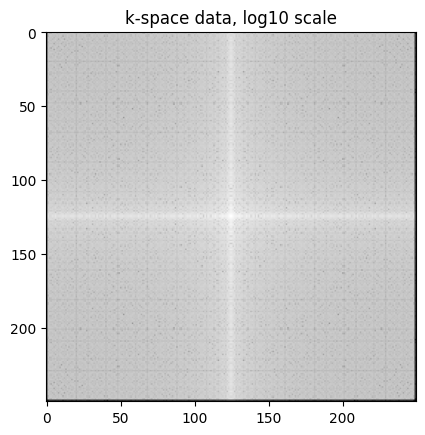

In [13]:
# plot the k-space data on log-scale
kdata_numpy = np.reshape(kdata.cpu().numpy(), (f*x_pixels,f*x_pixels))
plt.imshow(np.log10(np.absolute(kdata_numpy)))
plt.gray()
plt.title('k-space data, log10 scale')
plt.show()

In [14]:
# adjnufft back
# method 1: no density compensation (blurry image)
image_blurry = adjnufft_ob(kdata, ktraj)

# method 2: use density compensation
dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
image_sharp = adjnufft_ob(kdata * dcomp, ktraj)

(250, 250)
(250, 250)


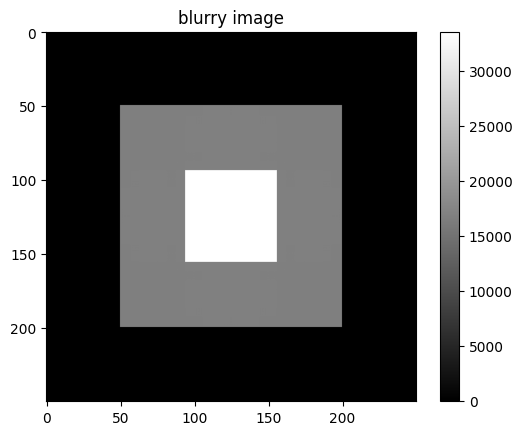

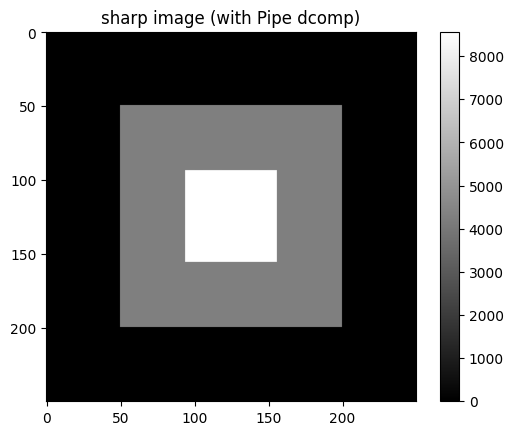

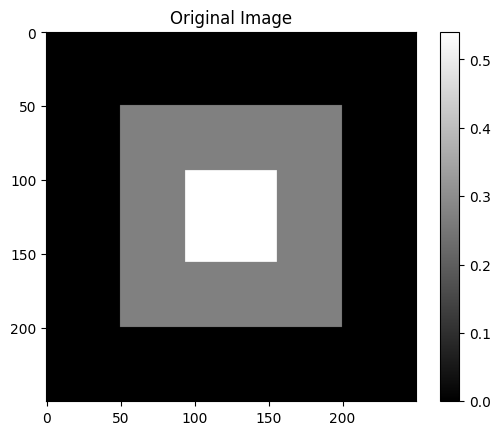

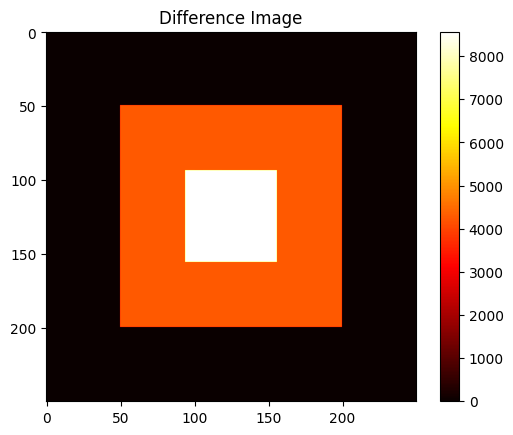

In [15]:
# show the images
image_blurry_numpy = np.squeeze(image_blurry.cpu().numpy())

image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())

print(image_sharp_numpy.shape)
print(image.shape)

diff_image = np.abs(image_sharp - image)
diff_image = np.squeeze(diff_image)

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy))
plt.gray()
plt.colorbar()
plt.title('blurry image')

plt.figure(1)
plt.imshow(np.absolute(image_sharp_numpy))
plt.gray()
plt.colorbar()
plt.title('sharp image (with Pipe dcomp)')

plt.figure(2)
plt.imshow(np.absolute(image))
plt.gray()
plt.colorbar()
plt.title('Original Image')

plt.figure(3)
plt.imshow(diff_image, cmap='hot')
plt.colorbar()
plt.title('Difference Image')

plt.show()


k-space trajectory shape: (2, 62500)


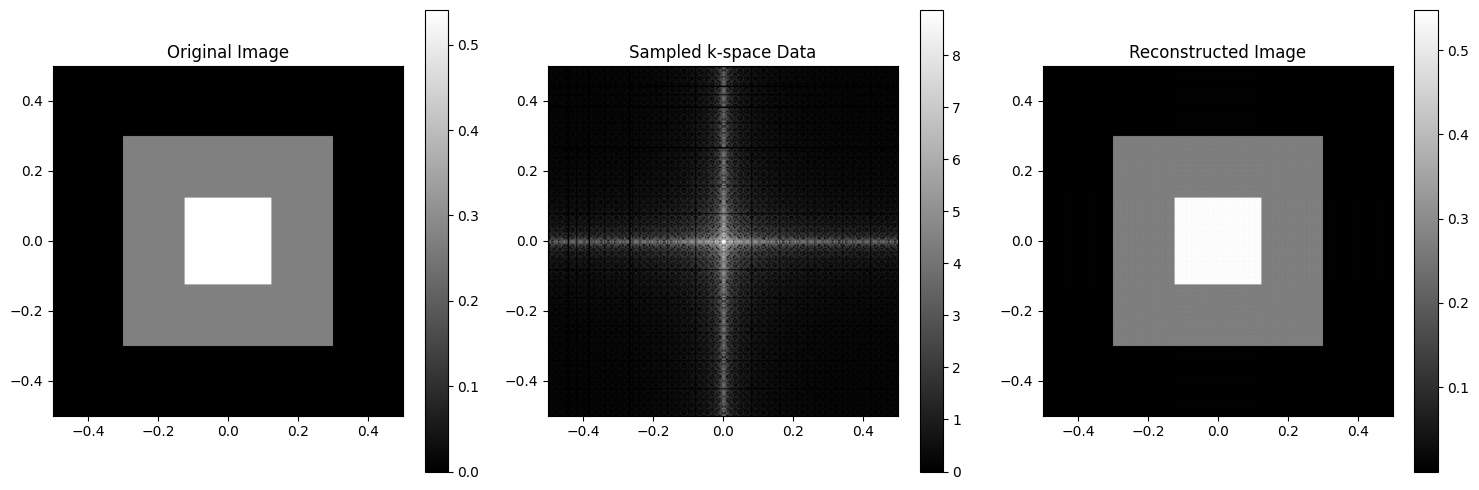

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define the image size (number of pixels along each dimension)
x_pixels = 250
y_pixels = 250

# Generate the k-space coordinates
kx = np.linspace(-0.5, 0.5, x_pixels, endpoint=False)  # Frequency space in x
ty = np.linspace(-0.5, 0.5, y_pixels, endpoint=False)  # Frequency space in y

# Create a Cartesian grid of k-space points
kx_grid, ky_grid = np.meshgrid(kx, ty, indexing='ij')

# Combine kx and ky into a single array
ktraj = np.stack((kx_grid.flatten(), ky_grid.flatten()), axis=0)

# ktraj is a 2xN array, where N = x_pixels * y_pixels
# Rows represent kx and ky coordinates

print("k-space trajectory shape:", ktraj.shape)

# Assume "image" is provided as input
# Perform forward FFT to simulate full k-space data
full_kspace_data = np.fft.fftshift(np.fft.fft2(image))

# Sample the k-space data using the k-space trajectory (ktraj)
sampled_kspace_data = np.zeros_like(full_kspace_data, dtype=complex)
for i in range(ktraj.shape[1]):
    kx_idx = int((ktraj[0, i] + 0.5) * x_pixels)  # Map normalized kx to pixel index
    ky_idx = int((ktraj[1, i] + 0.5) * y_pixels)  # Map normalized ky to pixel index
    sampled_kspace_data[kx_idx % x_pixels, ky_idx % y_pixels] = full_kspace_data[kx_idx % x_pixels, ky_idx % y_pixels]

# Perform inverse FFT to reconstruct the image from sampled k-space
reconstructed_image = np.fft.ifft2(np.fft.ifftshift(sampled_kspace_data))
reconstructed_image = np.abs(reconstructed_image)  # Take magnitude

# Visualize the original image, sampled k-space, and reconstructed image
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', extent=(-0.5, 0.5, -0.5, 0.5))
plt.title("Original Image")
plt.colorbar()

# Sampled k-space data
plt.subplot(1, 3, 2)
plt.imshow(np.log1p(np.abs(sampled_kspace_data)), cmap='gray', extent=(-0.5, 0.5, -0.5, 0.5))
plt.title("Sampled k-space Data")
plt.colorbar()

# Reconstructed image
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image, cmap='gray', extent=(-0.5, 0.5, -0.5, 0.5))
plt.title("Reconstructed Image")
plt.colorbar()

plt.tight_layout()
plt.show()
